# Introduction to Q-Learning

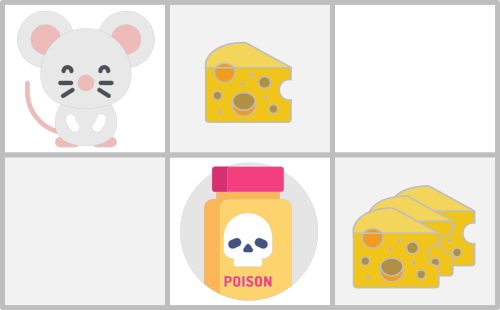

Inspiration: https://huggingface.co/learn/deep-rl-course/en/unit2/q-learning-example

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy

### Set up the problem

In [3]:
# Define environment parameters
n_rows = 3
n_cols = 3
n_actions = 4  # Up, Down, Left, Right

# Define the initial Q-table with zeros
q_table = np.zeros((n_rows * n_cols, n_actions))

In [4]:
# Define the rewards and game over conditions
rewards = np.zeros((n_rows, n_cols))
rewards[1, 2] = 10  # Big piece of cheese
rewards[0, 1] = 1 # Small piece of cheese
rewards[1, 1] = -10  # Poison
game_over_positions = [(1, 2), (1, 1)]

### Apply Training

In [5]:
def get_valid_actions(position:tuple, n_rows:int, n_cols:int):
    """Returns a list of valid actions given a position and the grid dimensions."""
    valid_actions = []
    if position[0] > 0:
        valid_actions.append(0)  # Up
    if position[0] < n_rows - 1:
        valid_actions.append(1)  # Down
    if position[1] > 0:
        valid_actions.append(2)  # Left
    if position[1] < n_cols - 1:
        valid_actions.append(3)  # Right
    return valid_actions

In [6]:
def choose_action(current_state, q_table, valid_actions, exploration_rate):
    """Choose an action based on epsilon-greedy strategy."""
    if np.random.uniform(0, 1) < exploration_rate:
        action = np.random.choice(valid_actions)
    else:
        state_index = current_state[0] * n_cols + current_state[1]  # Index from flattened state
        q_values = q_table[state_index, valid_actions]
        max_q_value = np.max(q_values)
        # Get all indices with maximum Q-value
        max_indices = np.where(q_values == max_q_value)[0]
        # Randomly choose one from the maximum indices
        action = np.random.choice(max_indices)
    return action

In [7]:
def update_state(current_state, action, n_rows, n_cols):
    """Update the current state based on the chosen action."""
    if action == 0:  # Up
        next_state = (max(0, current_state[0] - 1), current_state[1])
    elif action == 1:  # Down
        next_state = (min(n_rows - 1, current_state[0] + 1), current_state[1])
    elif action == 2:  # Left
        next_state = (current_state[0], max(0, current_state[1] - 1))
    else:  # Right
        next_state = (current_state[0], min(n_cols - 1, current_state[1] + 1))
    return next_state

In [8]:
def get_reward(state, rewards, penalty=0):
    """
    Calculate the reward based on the given transition.
    """
    base_reward = rewards[state[0], state[1]]
    reward = base_reward + penalty
    return reward

In [9]:
def update_q_table(q_table, current_state, action, next_state, reward, learning_rate, discount_factor, n_cols):
    """Update the Q-table using the Bellman equation."""
    current_state_index = current_state[0] * n_cols + current_state[1]
    next_state_index = next_state[0] * n_cols + next_state[1]

    max_next_q_value = np.max(q_table[next_state_index])

    q_table[current_state_index, action] = (1 - learning_rate) * q_table[current_state_index, action] + \
                                           learning_rate * (reward + discount_factor * max_next_q_value)

    return q_table

In [10]:
# Q-learning parameters
learning_rate = 0.8
discount_factor = 0.9
exploration_rate = 0.9
exploration_decay = 0.9
n_episodes = 10000
print_statements = False

# Spell out Action names
action_names = ['Up', 'Down', 'Left', 'Right']

In [11]:
# Q-learning algorithm
for episode in range(n_episodes):
    # Reset the environment to the starting position
    current_state = (0, 0)
    current_exploration_rate = deepcopy(exploration_rate)

    if current_state in game_over_positions:
        continue

    while True:
        # Get the list of valid actions for the current state
        valid_actions = get_valid_actions(current_state, n_rows, n_cols)
        
        # Choose an action based on epsilon-greedy strategy
        action = choose_action(current_state, q_table, valid_actions, exploration_rate)

        # Update the current state based on the chosen action
        next_state = update_state(current_state, action, n_rows, n_cols)

        # Get the reward for the new state
        reward = get_reward(next_state, rewards)

        # Update the Q-table using the Bellman equation
        q_table = update_q_table(q_table, current_state, action, next_state, reward, learning_rate, discount_factor, n_cols)

        # Print the current state of the environment
        if print_statements:
            print(f"Episode: {episode + 1}")
            print(f"Exploration rate: {current_exploration_rate:.2f}")
            print(f"Current state: {current_state}")
            print(f"The valid actions are {valid_actions}") 
            print(f"The available actions are: {list(map(lambda action: action_names[action], valid_actions))}.")
            print(f"The chosen action is {action}")
            print(f"The direction is {action_names[action]}.")
            print(f"The next state is {next_state}.")
            print(f"The reward for the new state is {reward}.")
            print(f"The updated Q-table is:\n{q_table}\n")

        # Move to the next state
        current_state = next_state

        # Update the exploration rate
        current_exploration_rate *= exploration_decay

        # Check if the episode is finished
        if current_state in game_over_positions:
            break

In [12]:
# Print the learned Q-table
print("Learned Q-table:")
q_table_df = pd.DataFrame(q_table, columns=action_names).round(2)
q_table_df

Learned Q-table:


,Up,Down,Left,Right
0,0.00,7.37,0.00,9.1
1,0.00,-10.00,8.19,9.0
2,9.00,10.00,9.10,0.0
3,8.19,7.29,0.00,-10.0
4,0.00,0.00,0.00,0.0
5,0.00,0.00,0.00,0.0
6,7.37,7.29,0.00,8.1
7,-10.00,0.00,7.29,9.0
8,10.00,0.00,8.10,0.0


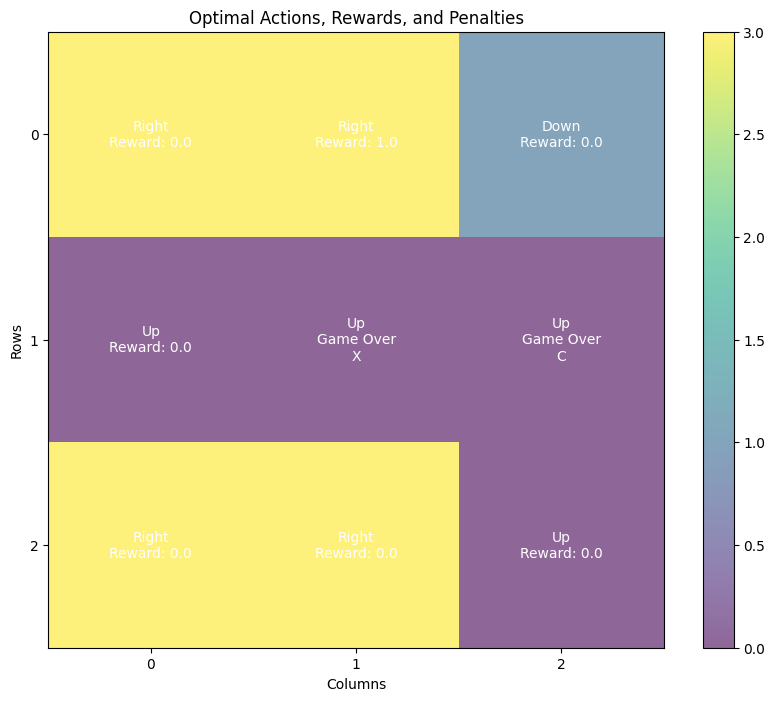

In [13]:
# Function to get optimal actions from the Q-table
def get_optimal_actions(q_table):
    return np.argmax(q_table, axis=1)

# Create a grid plot with colored cells indicating optimal actions, rewards, and penalties
def plot_optimal_actions_and_rewards(q_table, rewards, action_names, n_rows, n_cols):
    optimal_actions = get_optimal_actions(q_table).reshape(n_rows, n_cols)

    plt.figure(figsize=(10, 8))
    plt.imshow(optimal_actions, cmap='viridis', interpolation='nearest', origin='upper', alpha=0.6)

    for i in range(n_rows):
        for j in range(n_cols):
            reward = rewards[i, j]

            if (i, j) in game_over_positions:
                if reward > 0:
                    marker = 'C'  # Use color 'C' for positive rewards
                else:
                    marker = 'X'  # Use 'X' for traps (negative rewards)
                plt.text(j, i, f'{action_names[optimal_actions[i, j]]}\nGame Over\n{marker}', ha='center', va='center', fontsize=10, color='white')
            else:
                plt.text(j, i, f'{action_names[optimal_actions[i, j]]}\nReward: {reward}', ha='center', va='center', fontsize=10, color='white')

    plt.title("Optimal Actions, Rewards, and Penalties")
    plt.xticks(range(n_cols), labels=range(n_cols))
    plt.yticks(range(n_rows), labels=range(n_rows))
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.colorbar()

    plt.show()

# Call the function to plot optimal actions, rewards, and penalties
plot_optimal_actions_and_rewards(q_table, rewards, action_names, n_rows, n_cols)

In [14]:
def print_optimal_actions(q_table, n_rows, n_cols):
    for row in range(n_rows):
        for col in range(n_cols):
            state_index = row * n_cols + col
            optimal_action = q_table.columns[np.argmax(q_table.iloc[state_index])]
            print(f"Optimal action for state ({row}, {col}): {optimal_action}")

# Call the function with your Q-table
print_optimal_actions(q_table_df, n_rows, n_cols)

Optimal action for state (0, 0): Right
Optimal action for state (0, 1): Right
Optimal action for state (0, 2): Down
Optimal action for state (1, 0): Up
Optimal action for state (1, 1): Up
Optimal action for state (1, 2): Up
Optimal action for state (2, 0): Right
Optimal action for state (2, 1): Right
Optimal action for state (2, 2): Up
